## Librerias

In [1]:
import re
import pandas as pd
import os

## Datos cammesa

### ETL from SADI

In [2]:
# Función para obtener los datos de un bloque y devolverlos en forma de diccionario
def obtener_datos_de_bloque(bloque):
    pares = re.findall(r'<th>(.*?)</th><td>(.*?)</td>', bloque)
    return dict(pares)

def documento_exportt(f):
    with open(f'./data/cammesa/sadi/{f}','r') as file:
        data = file.read()

    # Dividir el contenido del archivo en bloques separados por '<tbody>'
    bloques = re.split(r'<tbody>', data)



    # Crear una lista de diccionarios con los datos de cada bloque
    datos_centrales = [obtener_datos_de_bloque(bloque) for bloque in bloques if bloque]

    # Crear el DataFrame
    df = pd.DataFrame(datos_centrales)
    # Extraer las columnas "lat" y "lon" de la columna "Ubicación (GD)" utilizando expresiones regulares
    df[['lat', 'lon']] = df['Ubicación (GD)'].str.extract(r'lat:\s*([\d.-]+),\s*lon:\s*([\d.-]+)')

    # Eliminar la columna "Ubicación (GMS)" y "Ubicación (GD)" ya que ahora tenemos las columnas "lat" y "lon"
    df.drop(["Ubicación (GMS)", "Ubicación (GD)"], axis=1, inplace=True)

    #Create a column with the name of the file 
    tipo = f.split('_')[1]
    #Drop the extension of the file
    tipo = tipo.split('.')[0]

    df['Tipo'] = tipo

    return df

files = os.listdir('./data/cammesa/sadi/')

for f in files:
    f_csv =  documento_exportt(f)
    #Save f_csv as csv filew with a diferent name for each file
    name = f.split('.')[0]
    f_csv.to_csv(f'./data/cammesa/sadi_csv/{name}.csv', sep=';')

In [5]:
#Open every file in sadi folder with the csv extesnion
sadi_files = os.listdir('./data/cammesa/sadi_csv/')
sadi_files = [f for f in sadi_files if f.endswith('.csv')]

#Create a list of dataframes

sadi_dfs = [pd.read_csv(f'./data/cammesa/sadi_csv/{f}', sep=';') for f in sadi_files]


In [10]:
#Junto todos los dataframes en uno solo
sadi = pd.concat(sadi_dfs)
sadi.to_csv(f'./data/cammesa/sadi_centrales.csv', sep=';')
sadi.head()


,Unnamed: 0,id,Nombre,Nemo,Tipo,Potencia,Region,F_desde,F_hasta,lat,lon
0,0,639.0,P.E. ARAUCO II (ETAPA 1 Y 2),AR21EO,eolicas,99.75,NOA,2015-01-01T03:00:00Z,9999-12-01T03:00:00Z,-28.713251,-66.705385
1,1,506.0,ARAUCO EOLICO,ARAUEO,eolicas,25.20,NOA,2015-01-01T03:00:00Z,9999-12-01T03:00:00Z,-28.701939,-66.752040
2,2,568.0,ARAUCO EOLICO 2,ARA2EO,eolicas,25.20,CUY,2015-01-01T03:00:00Z,9999-12-01T03:00:00Z,-28.692980,-66.754425
3,3,614.0,EL JUME,JUMEEO,eolicas,8.00,NOA,2015-01-01T03:00:00Z,9999-12-01T03:00:00Z,-29.419391,-63.709658
4,4,669.0,P.E. Achiras,ACHIEO,eolicas,48.00,CEN,2015-01-01T03:00:00Z,9999-12-01T03:00:00Z,-33.213184,-65.080059


### EDA

EDA con los datos obtenidos de SADI y las provincias correspondientes a cada central

In [67]:
centrales = pd.read_csv('./data/cammesa/data_con_provincias.csv',sep=',')

In [68]:
centrales.head()

,Unnamed: 0.1,Unnamed: 0,id,Nombre,Nemo,Tipo,Potencia,Region,F_desde,F_hasta,lat,lon,provincia
0,0,0,639.0,P.E. ARAUCO II (ETAPA 1 Y 2),AR21EO,eolicas,99.75,NOA,2015-01-01T03:00:00Z,9999-12-01T03:00:00Z,-28.713251,-66.705385,La Rioja
1,1,1,506.0,ARAUCO EOLICO,ARAUEO,eolicas,25.20,NOA,2015-01-01T03:00:00Z,9999-12-01T03:00:00Z,-28.701939,-66.752040,La Rioja
2,2,2,568.0,ARAUCO EOLICO 2,ARA2EO,eolicas,25.20,CUY,2015-01-01T03:00:00Z,9999-12-01T03:00:00Z,-28.692980,-66.754425,La Rioja
3,3,3,614.0,EL JUME,JUMEEO,eolicas,8.00,NOA,2015-01-01T03:00:00Z,9999-12-01T03:00:00Z,-29.419391,-63.709658,Santiago del Estero
4,4,4,669.0,P.E. Achiras,ACHIEO,eolicas,48.00,CEN,2015-01-01T03:00:00Z,9999-12-01T03:00:00Z,-33.213184,-65.080059,Córdoba


In [69]:
#drop columns 0 y 1
centrales.drop(['Unnamed: 0.1','Unnamed: 0'], axis=1, inplace=True)


In [70]:
#Remplazo Ciudad autonoma de buenos aires por CABA
centrales['provincia'] = centrales['provincia'].replace('Ciudad Autónoma de Buenos Aires','CABA')

In [79]:
#Si la central pertenece a eolica, solar o hidraulica, agrego columna con valor Renovable
#centrales['Tipo_eco'] = centrales['Tipo'].apply(lambda x: 'Renovable' if x in ['eolicas','solar','hidraulica'] else 'No Renovable')
#Pongo de transicion si es de tipo nuclear y mantengo la anterior clasificacion
centrales['Tipo_eco'] = centrales['Tipo'].apply(lambda x: 'Transicion' if x in ['nuclear'] else 'Renovable' if x in ['eolicas','solar','hidraulica'] else 'No Renovable')  


In [52]:
#Save centrales as sadi.csv file
centrales.to_csv('./data/cammesa/centrales.csv', sep=',')

In [80]:
centrales


,id,Nombre,Nemo,Tipo,Potencia,Region,F_desde,F_hasta,lat,lon,provincia,Tipo_eco
0,639.0,P.E. ARAUCO II (ETAPA 1 Y 2),AR21EO,eolicas,99.75,NOA,2015-01-01T03:00:00Z,9999-12-01T03:00:00Z,-28.713251,-66.705385,La Rioja,Renovable
1,506.0,ARAUCO EOLICO,ARAUEO,eolicas,25.20,NOA,2015-01-01T03:00:00Z,9999-12-01T03:00:00Z,-28.701939,-66.752040,La Rioja,Renovable
2,568.0,ARAUCO EOLICO 2,ARA2EO,eolicas,25.20,CUY,2015-01-01T03:00:00Z,9999-12-01T03:00:00Z,-28.692980,-66.754425,La Rioja,Renovable
3,614.0,EL JUME,JUMEEO,eolicas,8.00,NOA,2015-01-01T03:00:00Z,9999-12-01T03:00:00Z,-29.419391,-63.709658,Santiago del Estero,Renovable
4,669.0,P.E. Achiras,ACHIEO,eolicas,48.00,CEN,2015-01-01T03:00:00Z,9999-12-01T03:00:00Z,-33.213184,-65.080059,Córdoba,Renovable
...,...,...,...,...,...,...,...,...,...,...,...,...
351,734.0,C.T. ARREBEEF ENERGIA,ABEF,termicas,1.50,BSAS,2015-01-01T03:00:00Z,9999-12-01T03:00:00Z,-33.762503,-60.090875,Buenos Aires,No Renovable
352,630.0,G ROJO R.ENERGY,ROJO,termicas,258.00,BSAS,2015-01-01T03:00:00Z,9999-12-01T03:00:00Z,-33.454965,-60.281668,Buenos Aires,No Renovable
353,100.0,ACEROS PARANA,APAR,termicas,150.00,BSAS,2015-01-01T03:00:00Z,9999-12-01T03:00:00Z,-33.364149,-60.145681,Buenos Aires,No Renovable
354,322.0,AES-PARANA,AESP,termicas,870.00,BSAS,2015-01-01T03:00:00Z,9999-12-01T03:00:00Z,-33.354883,-60.171846,Buenos Aires,No Renovable


In [81]:
centrales['Tipo_eco'].value_counts()

Tipo_eco
No Renovable    201
Renovable       152
Transicion        3
Name: count, dtype: int64

In [42]:
#Grafico en un mapa las centrales
import folium

# Crear un mapa centrado en la Argentina
mapa = folium.Map(location=[-34.6, -58.4], zoom_start=4)


# Agregar un marcador por cada central y disitngo con color en base al tipo de central
for indice, central in centrales.iterrows():
    folium.Marker(
        location=[central['lat'], central['lon']],
        popup=central['Nombre'],
        #Cada icono tiene el color segun el tipo de central
        icon = folium.Icon(color=central['Tipo'], icon='bolt', prefix='fa')
        #icon=folium.Icon(color='red', icon='bolt', prefix='fa')
    ).add_to(mapa)
# Mostrar el mapa
mapa

/tmp/ipykernel_21675/796731838.py:14: UserWarning: color argument of Icon should be one of: {'darkblue', 'purple', 'gray', 'cadetblue', 'green', 'white', 'lightgreen', 'red', 'lightblue', 'lightred', 'pink', 'black', 'orange', 'darkgreen', 'lightgray', 'darkpurple', 'beige', 'blue', 'darkred'}.
  icon = folium.Icon(color=central['Tipo'], icon='bolt', prefix='fa')


In [43]:
#Agregar un mapa de densidad de calor
from folium.plugins import HeatMap

# Crear un mapa centrado en la Argentina
mapa = folium.Map(location=[-34.6, -58.4], zoom_start=4)

# Crear un mapa de calor con la potencia de cada central
HeatMap(data=centrales[['lat', 'lon', 'Potencia']].values.tolist(), radius=15).add_to(mapa)

# Mostrar el mapa
mapa


Potencia instalada por Region

/tmp/ipykernel_21675/3863492217.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=centrales, x='Region', y='Potencia', estimator=sum, ci=None)


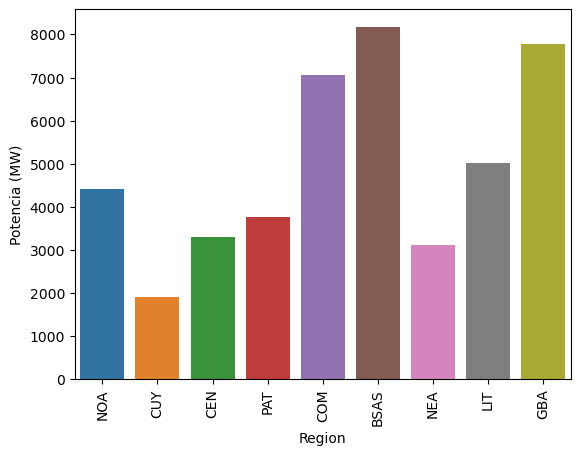

In [44]:
#Histograma de potencia instalada por provincia
import matplotlib.pyplot as plt
import seaborn as sns

# Crear un gráfico de barras con la potencia instalada por provincia
sns.barplot(data=centrales, x='Region', y='Potencia', estimator=sum, ci=None)

plt.xticks(rotation=90)
plt.ylabel('Potencia Instalada (MW)')

# Mostrar el gráfico
plt.show()


Potencia instalada por provincia

/tmp/ipykernel_21675/3560571297.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=centrales, x='provincia', y='Potencia', estimator=sum, ci=None)


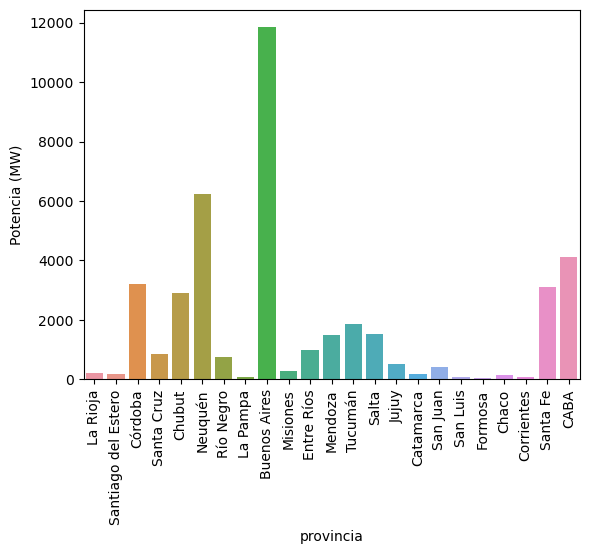

In [54]:
#Histograma de potencia instalada por provincia
# Crear un gráfico de barras con la potencia instalada por provincia
sns.barplot(data=centrales, x='provincia', y='Potencia', estimator=sum, ci=None)

plt.xticks(rotation=90)
plt.ylabel('Potencia Instalada (MW)')

# Mostrar el gráfico
plt.show()


In [56]:
#Identificar en el mapa las centrales con amyor potencia instalada
# Crear un mapa centrado en la Argentina
mapa = folium.Map(location=[-34.6, -58.4], zoom_start=4)

# Selecionar las 10 centrales con mayor potencia instalada
sadi_top10 = centrales.sort_values(by='Potencia', ascending=False).head(10)

# Agregar un marcador por cada central
for indice, central in sadi_top10.iterrows():
    folium.Marker(
        location=[central['lat'], central['lon']],
        popup=central['Nombre'],
        icon=folium.Icon(color='red', icon='bolt', prefix='fa')
    ).add_to(mapa)

# Mostrar el mapa
mapa



###

/tmp/ipykernel_21675/601148694.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=centrales, x='Tipo', y='Potencia', estimator=sum, ci=None)


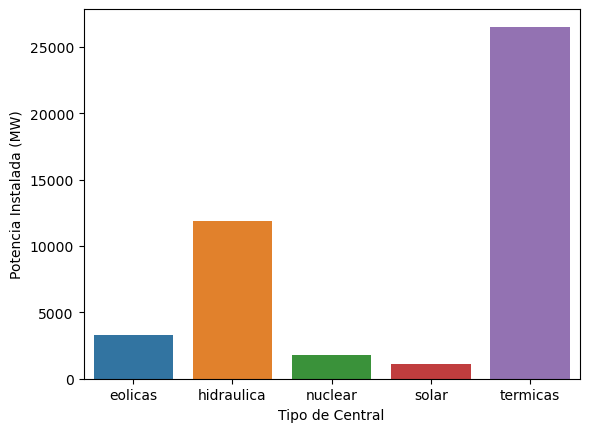

In [64]:
#Analizo la potencia instalada por tipo de central
# Crear un gráfico de barras con la potencia instalada por tipo de central
sns.barplot(data=centrales, x='Tipo', y='Potencia', estimator=sum, ci=None)

plt.xticks(rotation=0)
plt.ylabel('Potencia Instalada (MW)')
plt.xlabel('Tipo de Central')

plt.show()

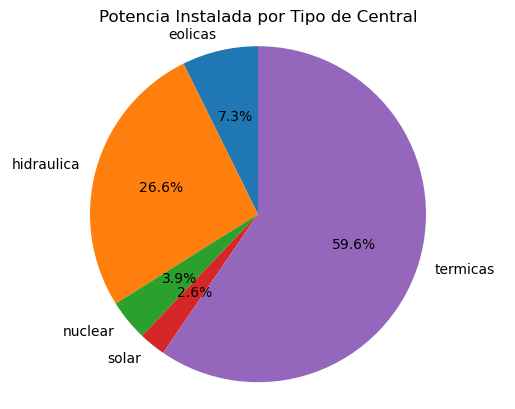

In [59]:
#Realizo un grafico de torta con la potencia instalada por tipo de central
# Crear un gráfico de torta con la potencia instalada por tipo de central
plt.pie(
    centrales.groupby('Tipo').sum()['Potencia'],
    labels=centrales.groupby('Tipo').sum()['Potencia'].index,
    autopct='%1.1f%%',
    shadow=False,
    startangle=90
)

plt.axis('equal')
plt.title('Potencia Instalada por Tipo de Central')
plt.show()



/tmp/ipykernel_21675/3355833409.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=centrales[centrales['provincia'] == 'Buenos Aires'], x='Tipo', y='Potencia', estimator=sum, ci=None)


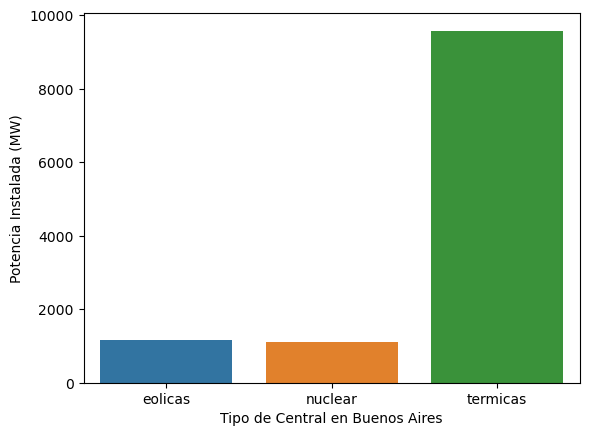

In [63]:
#Analisis de los tipos de tipos de centrales en Buenos Aires
# Crear un gráfico de barras con la potencia instalada por tipo de central
sns.barplot(data=centrales[centrales['provincia'] == 'Buenos Aires'], x='Tipo', y='Potencia', estimator=sum, ci=None)

plt.xticks(rotation=0)
plt.ylabel('Potencia Instalada (MW)')
plt.xlabel('Tipo de Central en Buenos Aires')

plt.show()
